# Import Libraries

Zuerst binden wir wie immer die Benutzen Bibliotheken ein.

In [2]:
from netgen.geom2d import *
import scipy
import scipy.sparse.linalg
import outsource
import matplotlib.pyplot as plt
import numpy as np
import warnings
from scipy.stats import unitary_group
from ngsolve import *
from ngsolve.webgui import Draw

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
warnings.simplefilter('ignore')

# Implemented QR-Algorithm

In [4]:
def QR_simple(A,tol = 1e-7):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):                   #i durchläuft {1,...,n} rückwärts 
        while abs(A[i,i-1]) > tol:              #in der Zeile ist immer labmda_i/lambda_{i-1} am größten
            Q,R = np.linalg.qr(A)               #QR-Zerlegung der  Matrix
            A = R@Q                             #RQ
            count +=1
        A[i,:i-n] = 0                           #Die Zeile wird bis zur Diagonale auf 0 gesetzt um sich aufschaukelnde Fehler zu vermeiden
    return A, sorted(np.diag(A)), count             

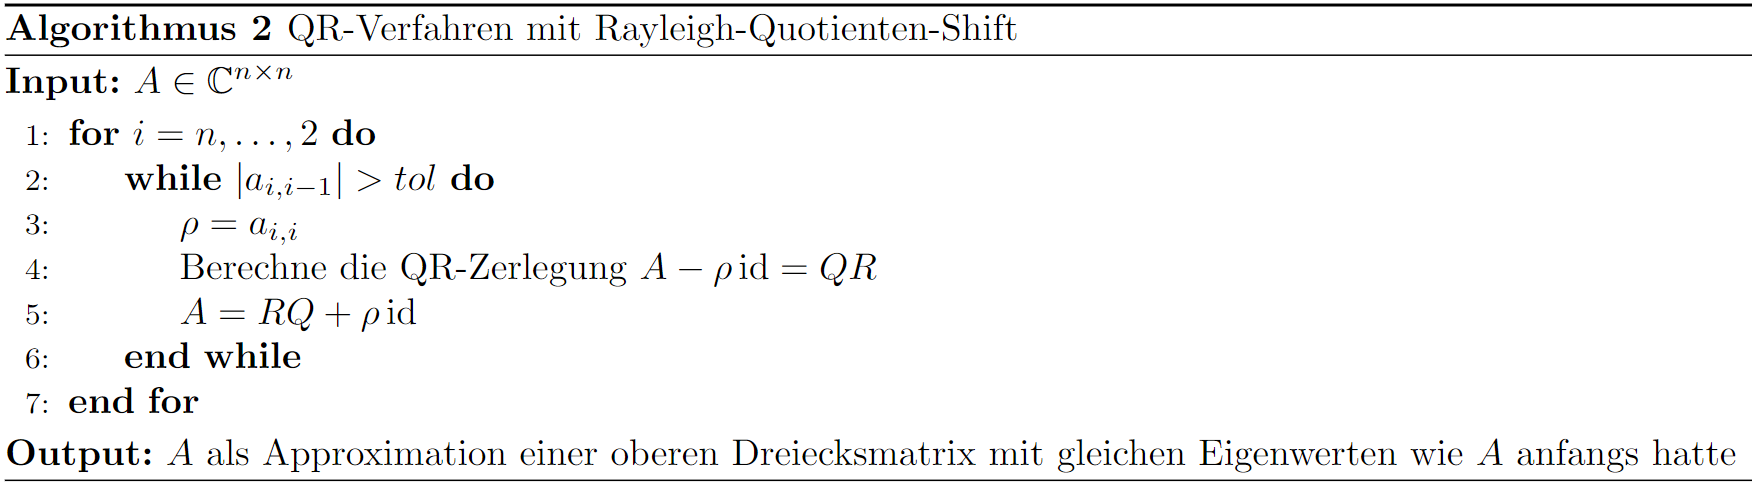

In [5]:
def QR_shift(A,tol=1e-10):
    n = A.shape[1]                                    #Dimension wird gespeichert
    count = 0
    for i in range(n-1,0,-1):                         #i durchläuft {1,...,n} rückwärts 
        while abs(A[i,i-1]) > tol:                    #in der Zeile ist immer labmda_i/lambda_{i-1} am größten
            rho = A[i,i]                              #Der Shift-Parameter
            Q,R = np.linalg.qr(A-rho*np.identity(n))  #QR-Zerlegung der geshifteten Matrix
            A = R@Q + rho*np.identity(n)              #RQ + Rückshift
            count +=1
        A[i,:i-n] = 0                                 #Die Zeile wird bis zur Diagonale auf 0 gesetzt um sich aufschaukelnde Fehler zu vermeiden
    return A, sorted(np.diag(A)), count

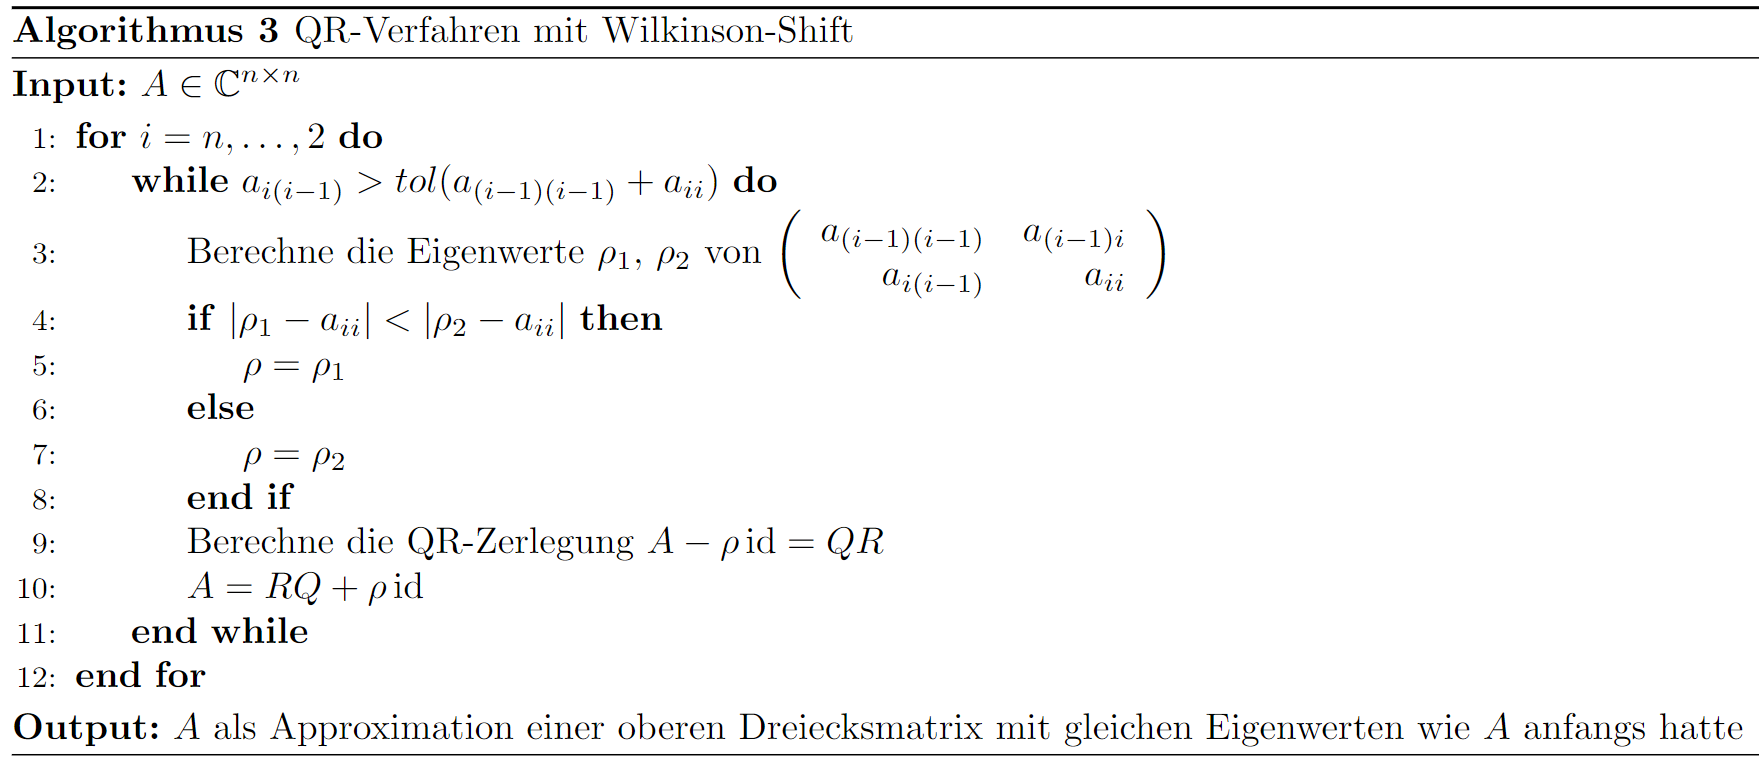

In [6]:
def QR_shift2(A,tol=1e-14):
    n = A.shape[1]                                                #Dimension wird gespeichert
    count = 0
    for i in range(n-1,0,-1):                                     #i durchläuft {1,...,n} rückwärts
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):  #Hier eine alternative Abbruchbedingung
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])             #Eigenwerte werden berechnet
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):           #Es wird überprüft, welcher der Eigenwerte näher am Diagonalelement ist
                rho = w[0]                                        #Wahl für den shift, falls 1 Eigenwert näher am Diagonalelement
            else:
                rho = w[1]                                        #Wahl für den shift, falls 2 Eigenwert näher am Diagonalelement
            Q,R = np.linalg.qr(A-rho*np.identity(n))              #QR-Zerlegung der geshifteten Matrix
            A = R@Q + rho*np.identity(n)                          #RQ + Rückshift
            count += 1
        A[i,:i-n] = 0                                             #Die Zeile wird bis zur Diagonale auf 0 gesetzt um sich aufschaukelnde Fehler zu vermeiden
    return A, sorted(np.diag(A)), count

In [6]:
n_arr = [10*i for i in range(1,4)]                                 #Dimension des Problems

k = len(n_arr)
eigv_array = []
for i in range(k):
    eigv_array.append(np.sort(5000*np.random.rand(n_arr[i])-250))  #Eigenwerte werden zufällig generiert

In [7]:
mat_array = []

for i in range(k):
    mat_array.append(outsource.gen_rand_mat(eigv_array[i]))         #Matrizen mit den Eigenwerten werden erstellt

In [8]:
time_1 = [0]*k
time_2 = [0]*k
time_3 = [0]*k

error_1 = [0]*k
error_2 = [0]*k
error_3 = [0]*k
for i in range(k):
    time_1[i], error_1[i] = outsource.runtime_error(QR_simple, mat_array[i], eigv_array[i])
    time_2[i], error_2[i] = outsource.runtime_error(QR_shift, mat_array[i], eigv_array[i])
    time_3[i], error_3[i] = outsource.runtime_error(QR_shift2, mat_array[i], eigv_array[i])

<IPython.core.display.Javascript object>


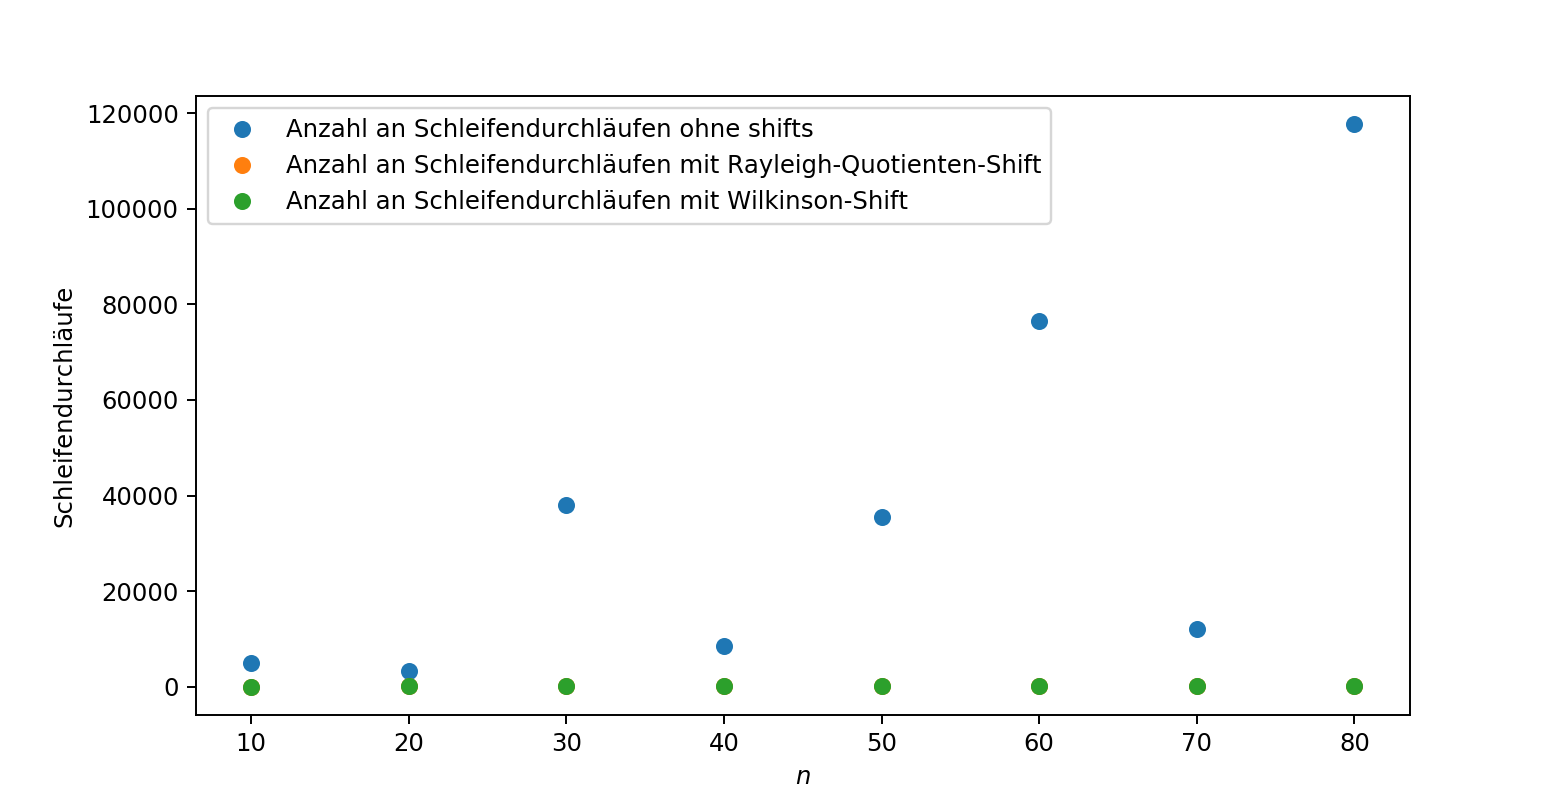

In [61]:
%matplotlib notebook

plt.plot(n_arr, time_1, 'o', label = "Anzahl an Schleifendurchläufen ohne shifts")
plt.plot(n_arr, time_2, 'o', label = "Anzahl an Schleifendurchläufen mit Rayleigh-Quotienten-Shift")
plt.plot(n_arr, time_3, 'o', label = "Anzahl an Schleifendurchläufen mit Wilkinson-Shift")

plt.ylabel("Schleifendurchläufe")
plt.xlabel("$n$")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


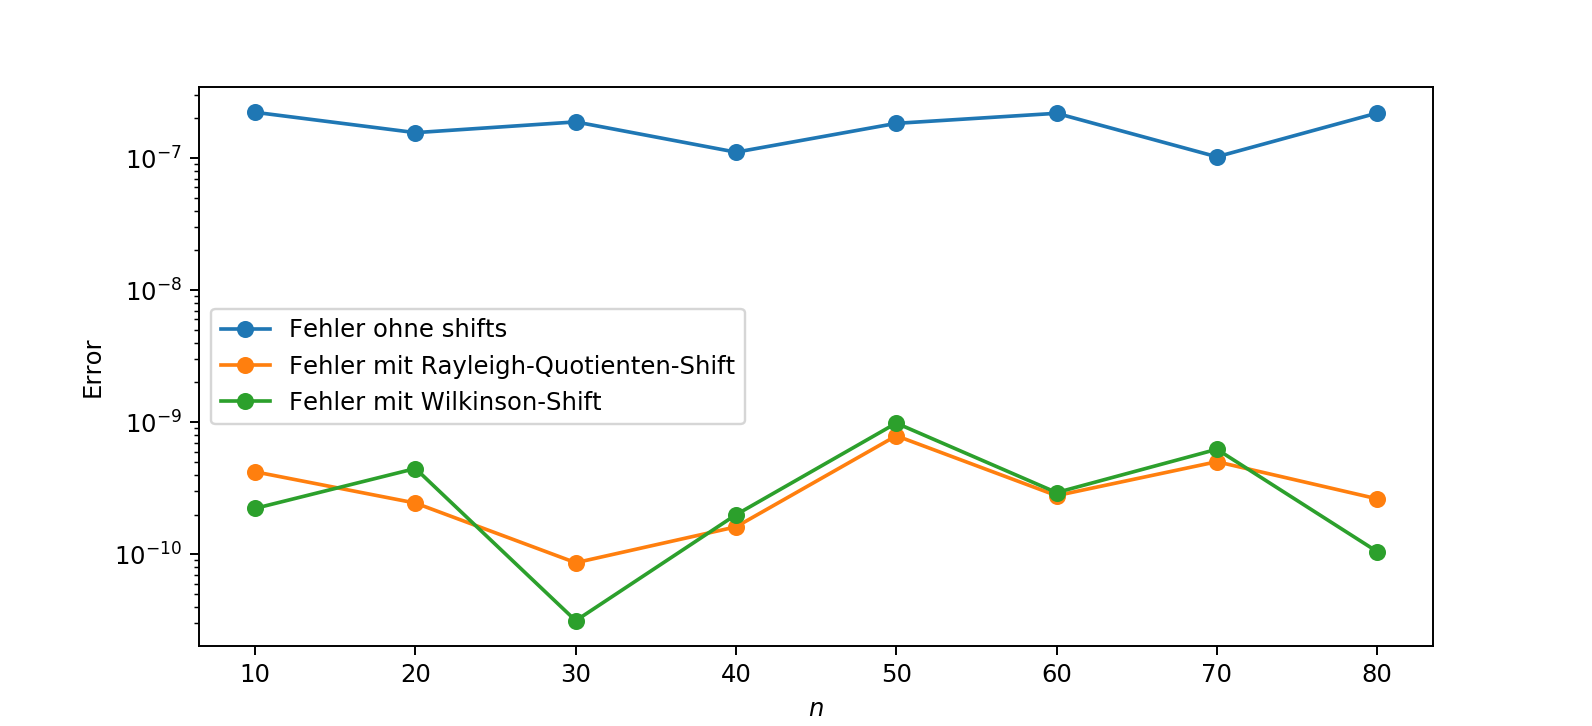

In [60]:
%matplotlib notebook

plt.semilogy(n_arr, error_1, '-o', label = "Fehler ohne shifts")
plt.semilogy(n_arr, error_2, '-o', label = "Fehler mit Rayleigh-Quotienten-Shift")
plt.semilogy(n_arr, error_3, '-o', label = "Fehler mit Wilkinson-Shift")

plt.ylabel("Error")
plt.xlabel("$n$")
plt.legend()
plt.show()

In [62]:
n_shifts = [10*i for i in range(1,20)]

len_shifts = len(n_shifts)

In [63]:
eigv_array_shifts = []
for i in range(len_shifts):
    eigv_array_shifts.append(np.sort(5000*np.random.rand(n_shifts[i])-250)) #Eigenwerte werden zufällig generiert

In [64]:
mat_array_shifts = []

for i in range(len_shifts):
    mat_array_shifts.append(outsource.gen_rand_mat(eigv_array_shifts[i]))

In [65]:
time_shifts1 = [0]*len_shifts
time_shifts2 = [0]*len_shifts

error_shifts1 = [0]*len_shifts
error_shifts2 = [0]*len_shifts

for i in range(len_shifts):
    time_shifts1[i], error_shifts1[i] = outsource.runtime_error(QR_shift, mat_array_shifts[i], eigv_array_shifts[i])
    time_shifts2[i], error_shifts2[i] = outsource.runtime_error(QR_shift2, mat_array_shifts[i], eigv_array_shifts[i])

In [ ]:
%matplotlib notebook

plt.plot(n_shifts, time_shifts1, 'o', label = "Anzahl an Schleifendurchläufen mit Rayleigh-Quotienten-Shift")
plt.plot(n_shifts, time_shifts2, 'o', label = "Anzahl an Schleifendurchläufen mit Wilkinson-Shift")

plt.ylabel("Schleifendurchläufe")
plt.xlabel("$n$")
plt.legend()
plt.show()

In [16]:
def QR_decomp_hesse(A):
    n = A.shape[0]
    Q = np.eye(n,n)

    for i in range(0,n-1):
        if abs(A[i,i]) >= abs(A[i+1,i]):                     #Überprüfen der Bedingung
            t = A[i+1,i]/abs(A[i,i])                         #Berechnung von t
            root = (1+abs(t)**2)**(1/2)                      #Ausdruck in der Wurzel
            c = A[i,i]/(abs(A[i,i])*root)                    #Berechnung von c
            s = t/root                                       #Berechnung von s
        else:
            t = A[i,i]/abs(A[i+1,i])                         #Berechnung von t
            root = (1+abs(t)**2)**(1/2)                      #Ausdruck in der Wurzel
            s = A[i+1,i]/(abs(A[i+1,i])*root)                #Berechnung von s
            c = t/root                                       #Berechnung von c
            
        for j in range(n):
            if j < i:                                        #Bis zum i-ten Index sind die Einträge a_{i,j} sowie a_{i+1,j} 0
                temp_2 = Q[i,j]                              #Zwischenspeichern des Eintrags, da dieser im nächsten Schritt überschireben wird
                Q[i,j] = c.conj()*temp_2 + s.conj()*Q[i+1,j] #Berechnung des neuen Eintrags    
                Q[i+1,j] = -s*temp_2 + c*Q[i+1,j]            #Berechnung des neuen Eintrags
            else:
                temp_1 = A[i,j]                              #Zwischenspeichern des Eintrags, da dieser im nächsten Schritt überschireben wird
                A[i,j] = c.conj()*temp_1 + s.conj()*A[i+1,j] #Berechnung der neuen Einträge  
                A[i+1,j] = -s*temp_1 + c*A[i+1,j]   
                temp_2 = Q[i,j]
                Q[i,j] = c.conj()*temp_2 + s.conj()*Q[i+1,j]     
                Q[i+1,j] = -s*temp_2 + c*Q[i+1,j]                                
            
    return Q.T.conj(), A

In [15]:
def QR_hesse(A,tol=1e-14):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = QR_decomp_hesse(A-rho*np.identity(n))            #Statt vorimplementierter QR-Zerlegung hier QR-Zerlegung mit Givens-Rotationen
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count

In [19]:
n_arr_1 = [10*i for i in range(1,20)]       #Dimension des Problems

k = len(n_arr_1)
    
mat_array_1 = []

for i in range(k):
    mat_array_1.append(outsource.gen_hess(n_arr_1[i])) #Hesseberg-Matrizen der Dimension n werden erstellt

In [20]:
time_givens = [0]*k
time_vorimplementiert = [0]*k

for i in range(k):
    time_givens[i] = outsource.runtime(QR_decomp_hesse, mat_array_1[i])
    time_vorimplementiert[i] = outsource.runtime(np.linalg.qr, mat_array_1[i])

<IPython.core.display.Javascript object>


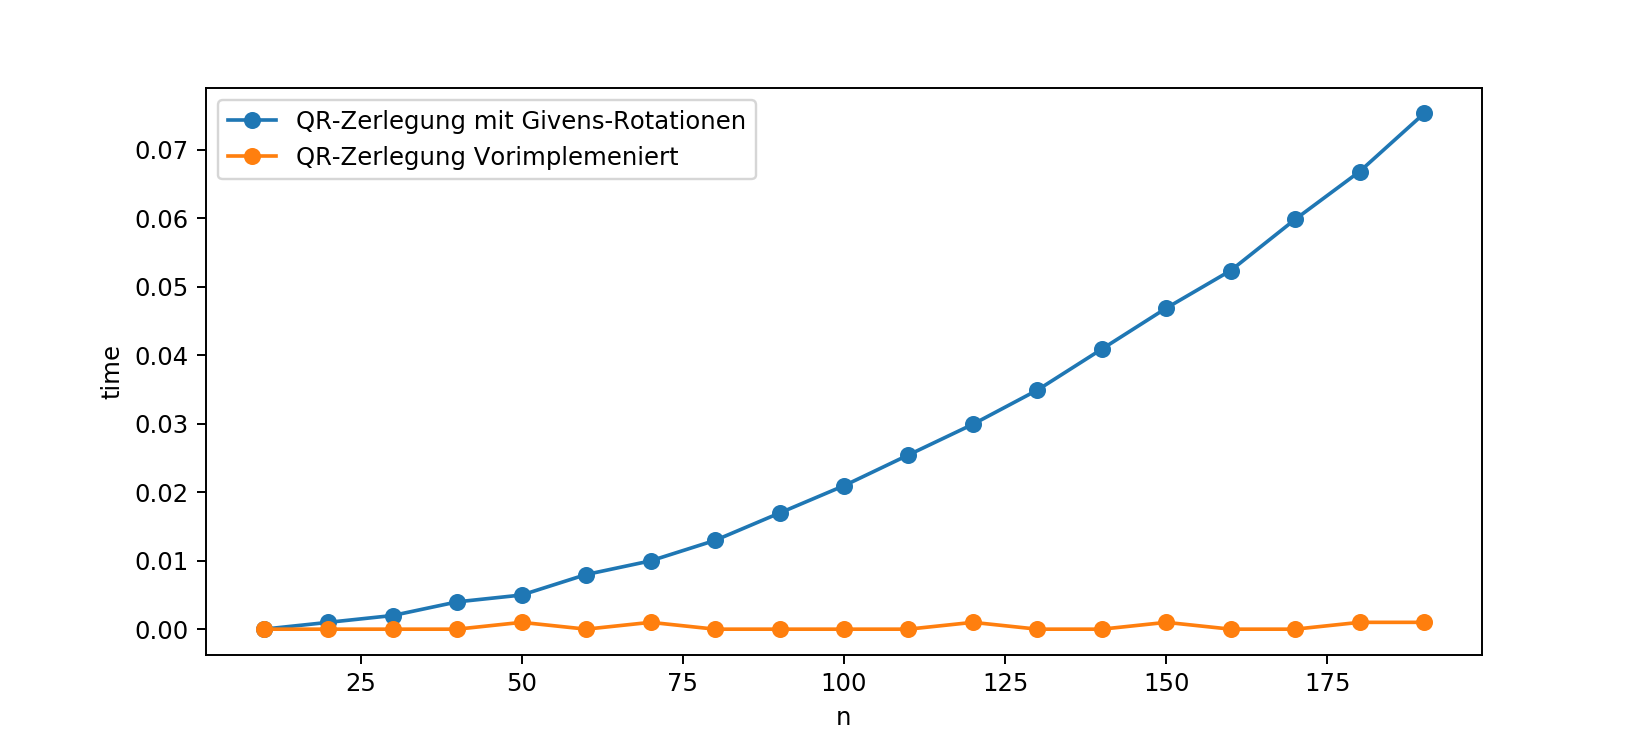

In [57]:
%matplotlib notebook

plt.plot(n_arr_1, time_givens, '-o', label = "QR-Zerlegung mit Givens-Rotationen")
plt.plot(n_arr_1, time_vorimplementiert, '-o', label = "QR-Zerlegung Vorimplemeniert")

plt.xlabel("n")
plt.ylabel("time")
plt.legend()
plt.show()

## Lanczos-Algorithm

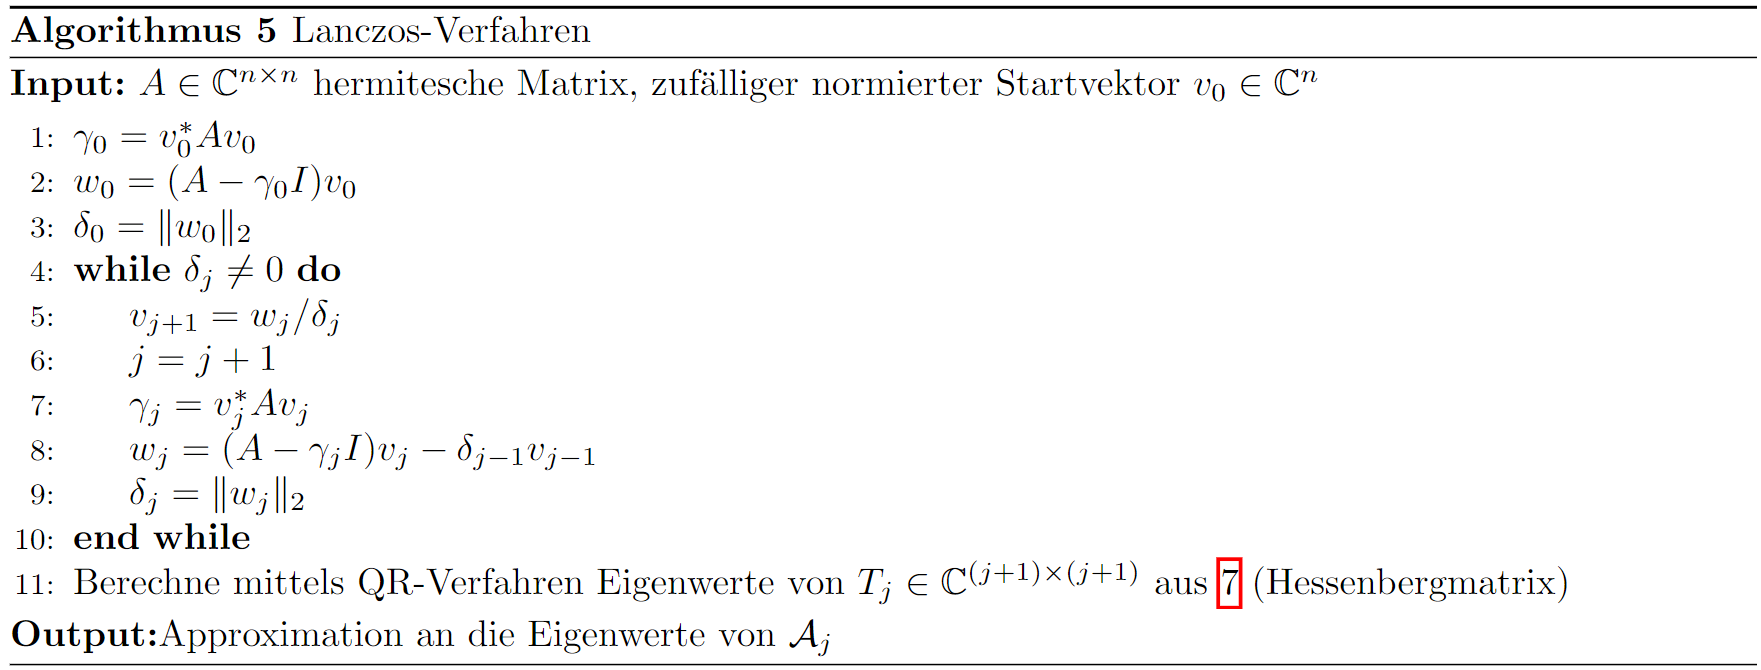

In [7]:
def lanczos(A,m = 0):                                                  #m sei die Anzahl der zu berechnenden Eigenwerte
    n = A.shape[1]
    if m == 0:                                                         #Wird keine Anzahl angegeben werden alle berechnet
        m = n
        
    v0 = np.random.rand(n)                                             #Randomisierter Startvektor wird gewählt
    v = [v0/np.linalg.norm(v0)]                                        #Normieren sowie Listenerstellung
    gam = [v[0].T.conj()@A@v[0]]                                       #Berechnung von gamma und Listenerstellung
    w = (A - gam[0]*np.identity(n))@v[0]                               #Berechnung des Vektors w
    delta = [np.linalg.norm(w)]                                        #Zugehörige Norm sowie Listenerstellung
    j = 0
    while delta[j] > 1e-10 and j < m-1:                                #Sobald delta zu 0 wird haben wir unsere ONB aus Eigenvektoren
        v.append(w/delta[j])                                           #Liste der v wird erweitert
        j +=1
        gam.append(v[j].T.conj()@A@v[j])                               #Berechnung von gamma und hinzufügen zur Liste
        w = (A - gam[j]*np.identity(n))@v[j] - delta[j-1]*v[j-1]       #Berechnung von w
        delta.append(np.linalg.norm(w))                                #Berechnung von delta und hinzufügen zur Liste
    T = np.diag(delta[:-1], -1) + np.diag(gam) + np.diag(delta[:-1], 1)#Erstellen der Tridiagonalmatrix T
    return QR_hesse(T)                                                 #Eigenwerte von T werden mit QR-Verfahren berechnet

In [10]:
n_dim = 1000                                              #Dimension des Problems

eigvalues = np.sort(500*np.random.rand(n_dim)-100)        #Eigenwerte werden zufällig generiert

In [11]:
mat_lan = outsource.gen_hermite(eigvalues)

In [12]:
dim_kyrlov = [i for i in range(40,100)]
dim_kyrlov_1 = [i for i in range(5,20)]
nr_approx_eigs = 2
nr_approx_eigs_1 = 3
k = len(dim_kyrlov)
k_1 = len(dim_kyrlov_1)

In [26]:
error_lanczos = np.zeros((nr_approx_eigs,k))

for i in range(k):
    lanczos_approx = lanczos(mat_lan, dim_kyrlov[i])[1]
    for l in range(nr_approx_eigs):
        error_lanczos[l][i] = abs(eigvalues[l-1]-lanczos_approx[l-1])

<IPython.core.display.Javascript object>


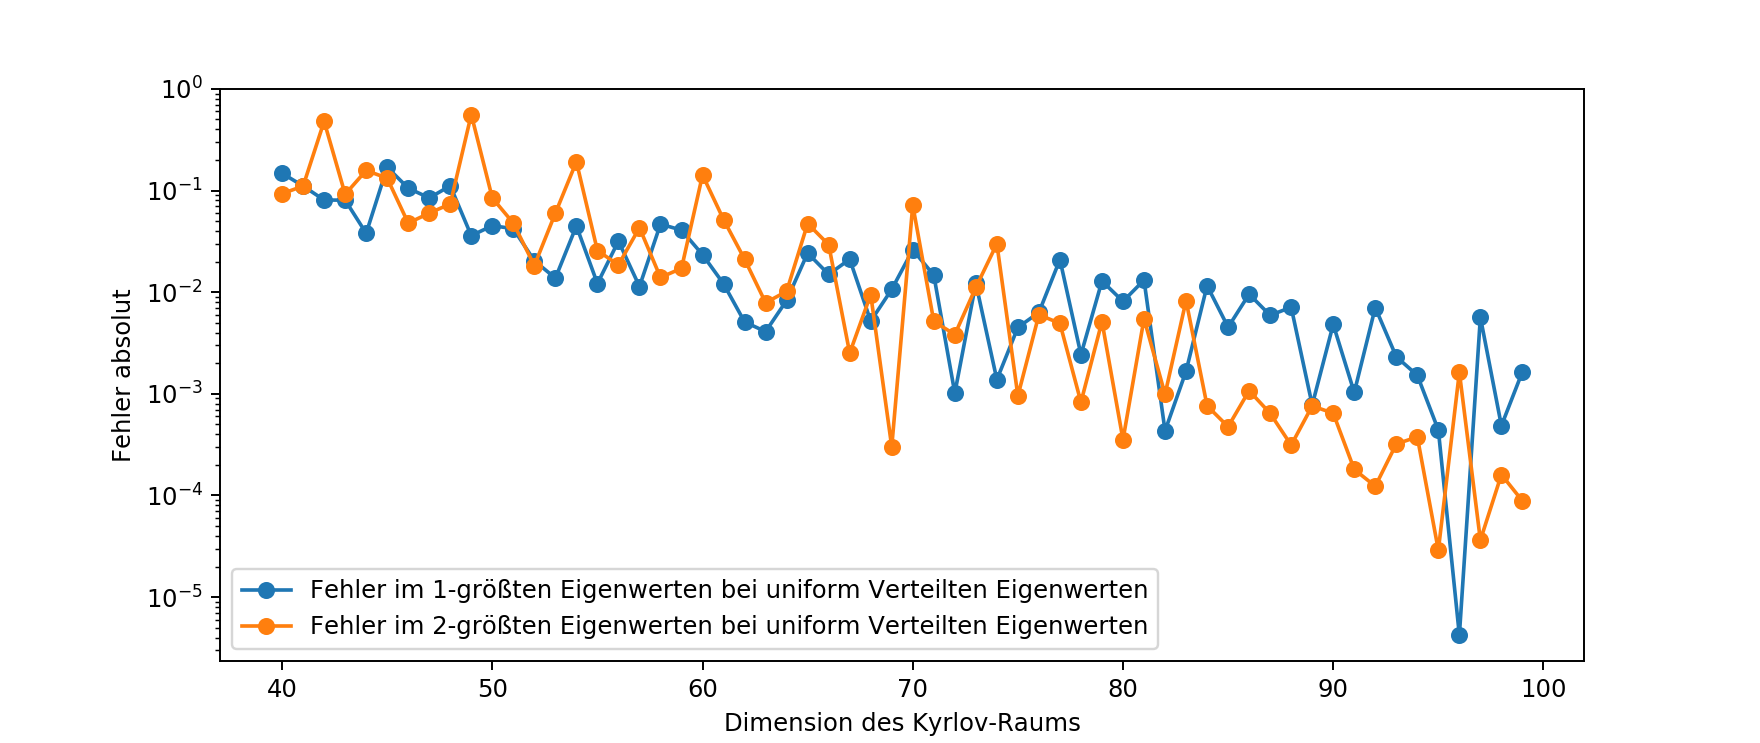

In [56]:
%matplotlib notebook

for l in range(nr_approx_eigs):
    plt.semilogy(dim_kyrlov, error_lanczos[l], '-o', label = "Fehler im {nr}-größten Eigenwerten bei uniform Verteilten Eigenwerten".format(nr = l+1))

plt.xlabel("Dimension des Kyrlov-Raums")
plt.ylabel("Fehler absolut")
plt.legend()

plt.show()

In [28]:
n_dim_2 = 500 

eigvalues_2 = np.sort(2*np.random.rand(n_dim))
eigvalues_2[-1] = 3
eigvalues_2[-2] = 2.5
eigvalues_2[0] = -1
eigvalues_2[1] = -0.5
L = outsource.gen_hermite(eigvalues_2)

j = 10

In [29]:
lanczos_arr = [[0]]*j

for l in range(j):
    lanczos_arr[l] = lanczos(L,l+2)[1]

<IPython.core.display.Javascript object>


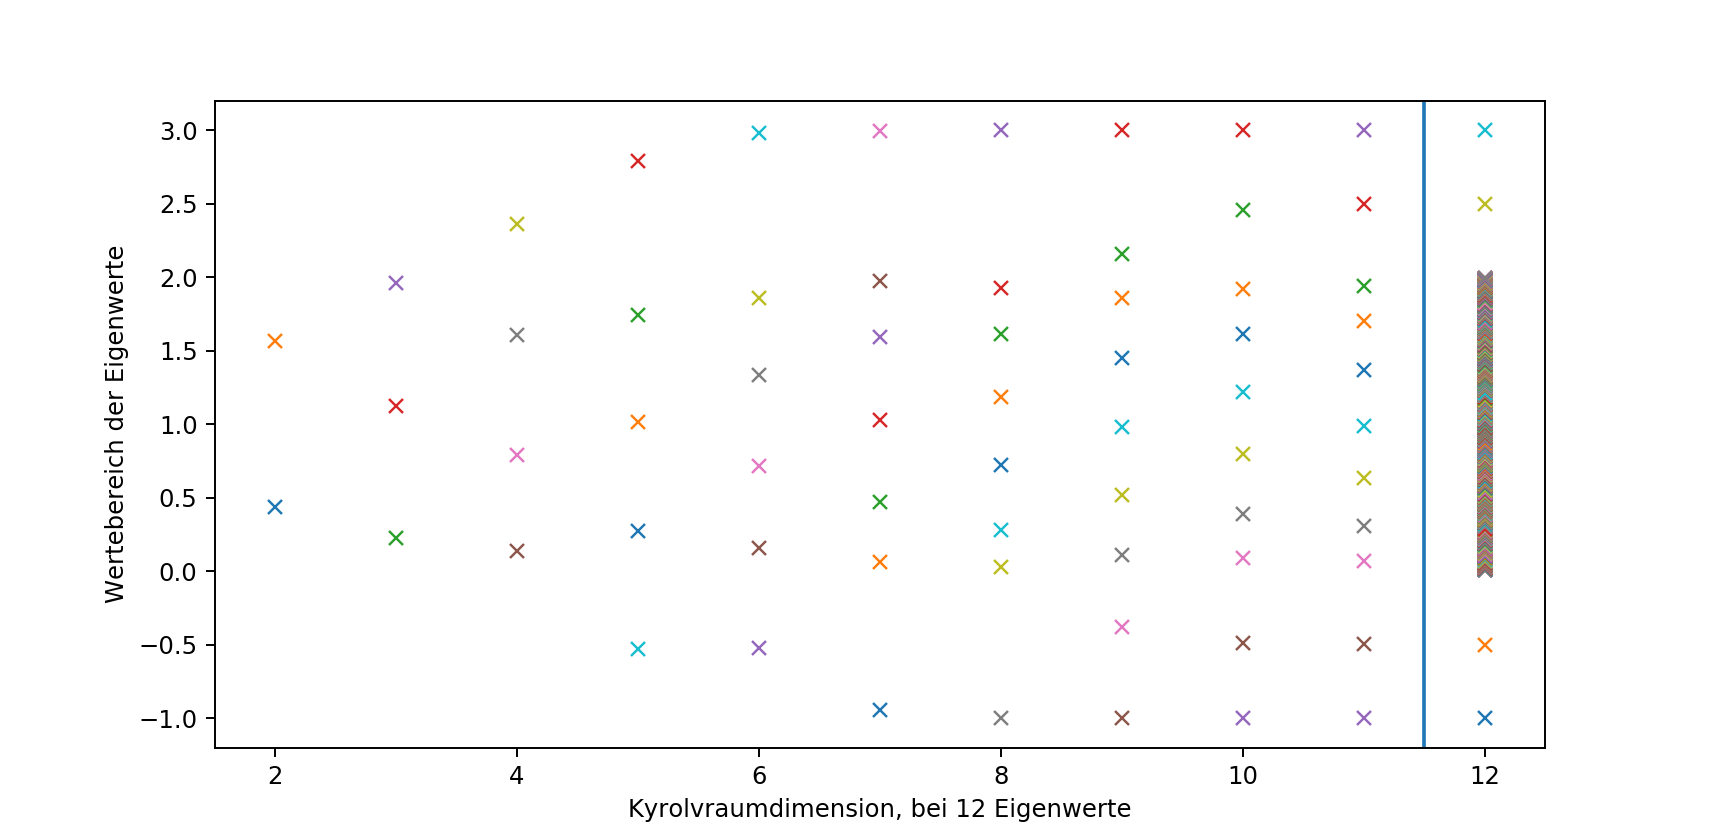

In [55]:
%matplotlib notebook

for l in range(n_dim):
    plt.plot(12,eigvalues_2[l], 'x')
for l in range(len(lanczos_arr)):
    for k in range(len(lanczos_arr[l])):
        plt.plot(l+2, lanczos_arr[l][k], 'x')
        
plt.axvline(x=11.5)

plt.xlabel("Kyrolvraumdimension, bei 12 Eigenwerte")
plt.ylabel("Wertebereich der Eigenwerte")
plt.show()

In [13]:
mu, sigma = 3, 1
eigvalues_1 = np.sort(np.random.lognormal(mu, sigma, n_dim))
    
mat_lan_2 = outsource.gen_hermite(eigvalues_1)

In [17]:
error_lanczos_1 = np.zeros((nr_approx_eigs_1,k_1))

for i in range(k_1):
    lanczos_approx = lanczos(mat_lan_2, dim_kyrlov_1[i])[1]
    for l in range(nr_approx_eigs_1):
        error_lanczos_1[l][i] = eigvalues_1[-l-1]-lanczos_approx[-l-1]

<IPython.core.display.Javascript object>


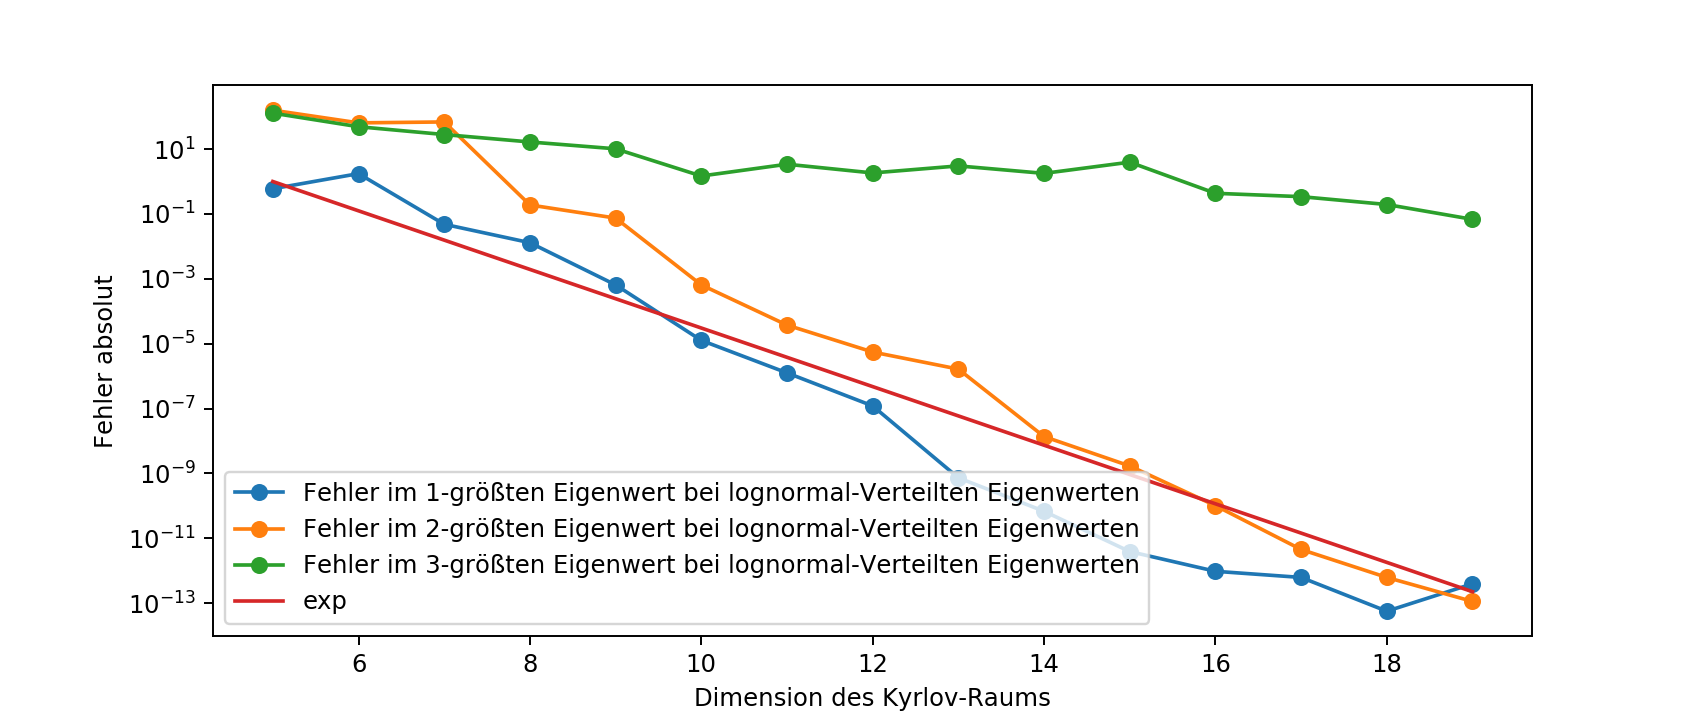

In [24]:
%matplotlib notebook
exp_arr = []
for l in range(len(dim_kyrlov_1)):
    exp_arr.append(1/(8)**l)
    
for l in range(nr_approx_eigs_1):
    plt.semilogy(dim_kyrlov_1, error_lanczos_1[l][:], '-o', label = "Fehler im {nr}-größten Eigenwert bei lognormal-Verteilten Eigenwerten".format(nr = l+1))
plt.semilogy(dim_kyrlov_1, exp_arr, label = "exp")
plt.xlabel("Dimension des Kyrlov-Raums")
plt.ylabel("Fehler absolut")
plt.legend()
plt.show()

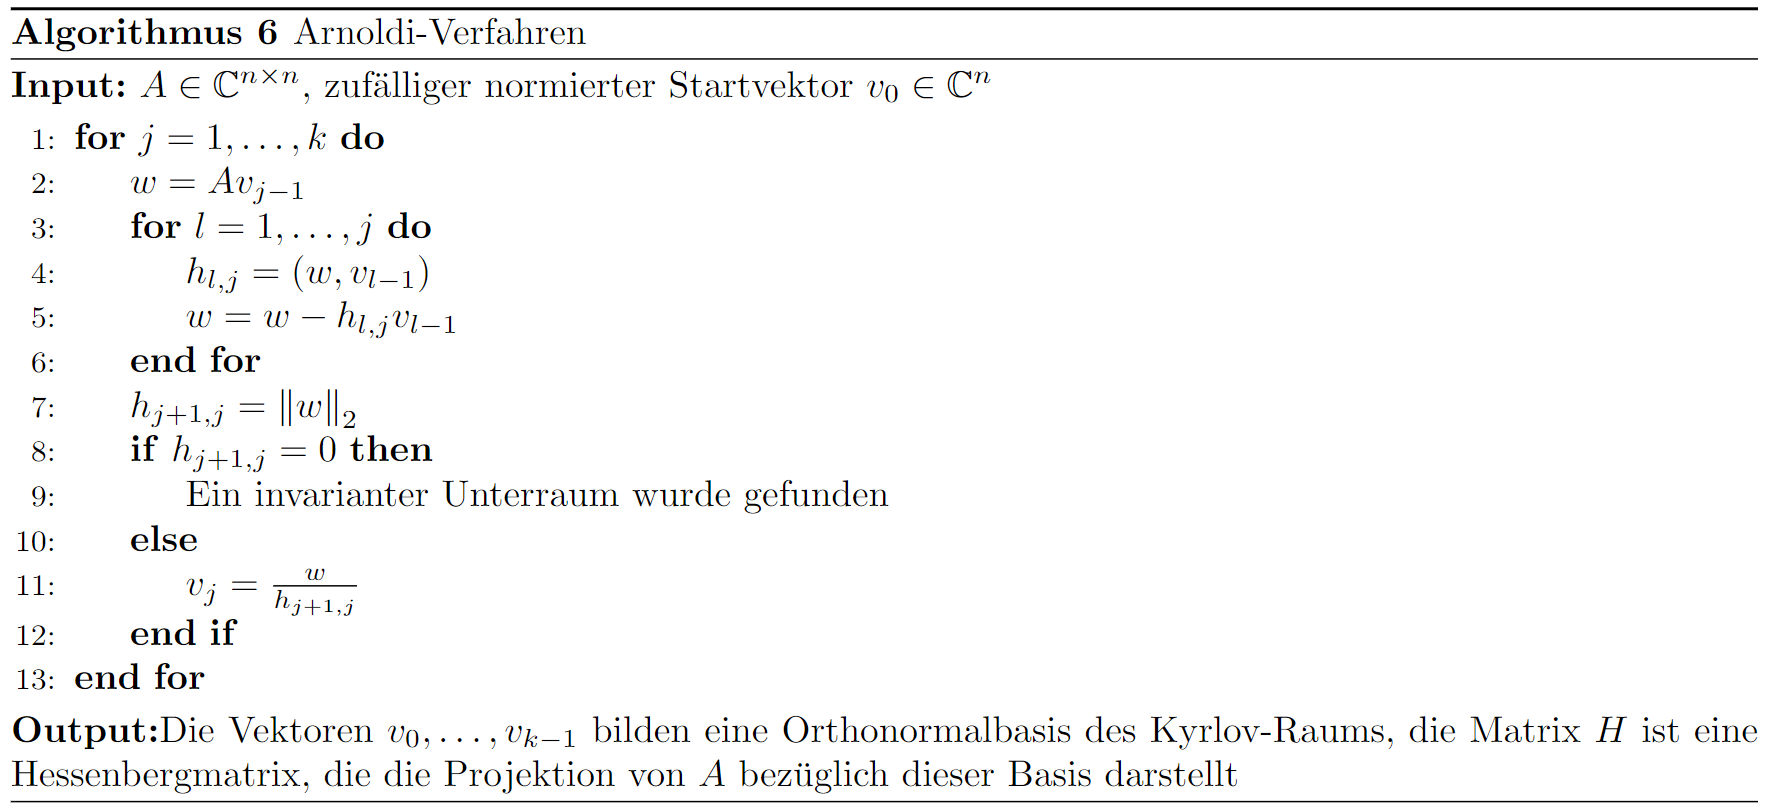

In [8]:
def arnoldi(A, dim, k = 0):                    #Hier wird die Dimension extra übergeben, da A nicht zwingend eine Matrix sein muss, sondern nur als Funktion übergeben werden kann
    n = dim
    if k == 0:                                 #Falls nicht näher angegeben, werden alle Eigenwerte berechnet
        k = n
        
    v0 = np.random.rand(n)                     #Random-Startvektor wird initialisiert
    v = [v0/np.linalg.norm(v0)]                #Der Vektor wird zusätzlich normiert
    h = np.zeros((k,k))                        #h ist die neue Matrix die erstellt wird, entspricht T aus dem Lanczos-Verfahern
    
    for j in range(k):
        w = A(v[j])                            #Entspricht A@v[j]
        for l in range(j+1):                   #Schleife für Orthogonalisierung nach Gram-Schmidt
            h[l][j] = v[l].T.conj()@w          #Enstpricht v[l]*@w = (v[l], w)
            w = w - h[l][j]*v[l]               #Gram-Schmidt Orthogonalisierung
        if j < k-1:                            #Nur im letzten Druchlauf nicht erfüllt
            h[j+1][j] = np.sqrt(w.T.conj()@w)  #sqrt((w,w)) zur Normierung
            if abs(h[j+1][j]) < 1e-14:         #Invarianter Unterraum gefunden, entspricht delta-Bedingung aus Lanczos
                return QR_hesse(h[:j+1,:j+1])  #Eigenwertberechnung der kleineren Matrix
            else:
                v.append(w/h[j+1][j])          #Normierter Vektor wird hinzugefügt
    
    return QR_hesse(h)

In [35]:
error_arnoldi = np.zeros((nr_approx_eigs_1, k_1))


for i in range(k_1):
    arnoldi_approx = arnoldi(lambda x: mat_lan_2@x, n_dim, dim_kyrlov_1[i])[1]
    for l in range(nr_approx_eigs_1):
        error_arnoldi[l][i] = eigvalues_1[-l-1]-arnoldi_approx[-l-1]

<IPython.core.display.Javascript object>


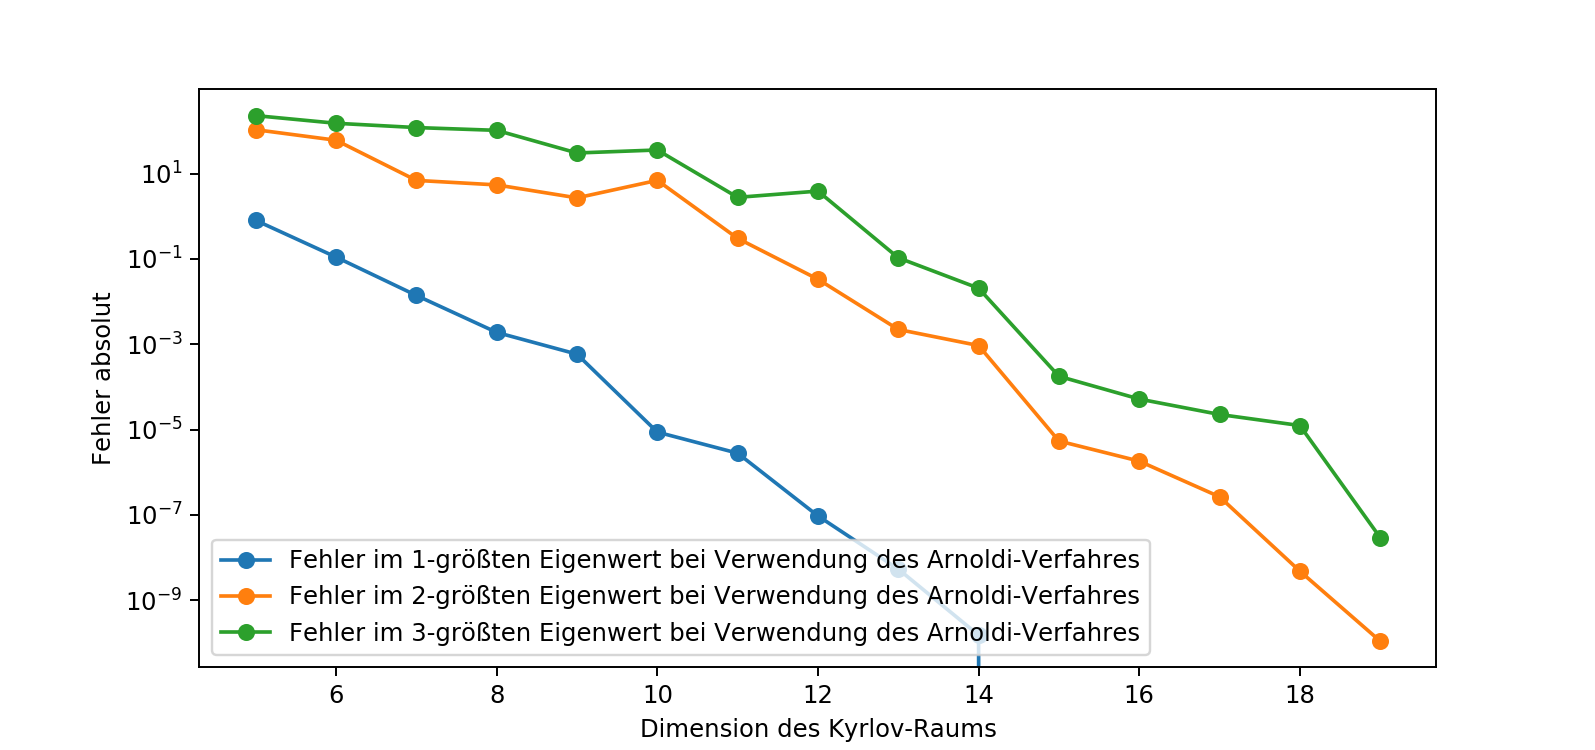

In [53]:
%matplotlib notebook

for l in range(nr_approx_eigs_1):
    plt.semilogy(dim_kyrlov_1, error_arnoldi[l][:], '-o', label = "Fehler im {nr}-größten Eigenwert bei Verwendung des Arnoldi-Verfahres".format(nr = l+1))

plt.xlabel("Dimension des Kyrlov-Raums")
plt.ylabel("Fehler absolut")
plt.legend()
plt.show()

## Applying the Arnoldi-Iteration to get eigenvalues of $-\Delta$ 

### Setting Ngsolve Parameters

In [45]:
a = 2                             # Length of rectangle in x direction 
b = 1                             # Length of rectangle in y direction 
R = 1                             # Radius of circle

maxh = 0.05                       # Mesh-size
order = 4                         # Order of Polynomials
nr_eigs = [50, 75, 100, 200]      # Number of Eigenvalues to approximate

### Create rectangle via Netgen

In [46]:
geo = SplineGeometry()
geo.AddRectangle((0,0), (a,b), bcs=["b","r","t","l"])


mesh = Mesh(geo.GenerateMesh(maxh=maxh))
Draw(mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

### FES and the bilinear- and linearform

In [47]:
fes = H1(mesh, complex=True, order=order)

eigenvec = GridFunction(fes,multidim=nr_eigs)

u = fes.TrialFunction()
v = fes.TestFunction()

a = BilinearForm (fes)
a += SymbolicBFI (grad(u)*grad(v))

b = BilinearForm (fes)
b += SymbolicBFI (u*v)

a.Assemble()
b.Assemble()

A=a.mat
B=b.mat

### Generate Matrices

In [48]:
shift = 3

shifted = a.mat.CreateMatrix()                                            #Matrix A wird aus NGSolve gewonnen
shifted.AsVector().data = a.mat.AsVector() - (shift**2)*b.mat.AsVector()  #A-shift^2 B
invshifted = shifted.Inverse(freedofs=fes.FreeDofs())                     #Inverse der Matrix wird berechnet

tmp1 = eigenvec.vec.CreateVector()
tmp2 = eigenvec.vec.CreateVector()

def matvec(v):                                                            #Realisiert die Multiplikation der   
    tmp1.FV().NumPy()[:] = v                                              #verallgemeinerten Matrix mit Vektor v
    tmp2.data = b.mat * tmp1
    tmp1.data = invshifted * tmp2
    return tmp1.FV().NumPy()

A = scipy.sparse.linalg.LinearOperator( (a.mat.height,a.mat.width), matvec)

print("Dimension der Matrix =", a.mat.height)

Dimension der Matrix = 15137


### Eigenvalues via arnoldi

In [49]:
mu_1 = arnoldi(A, a.mat.height, nr_eigs[0])[1]                  #Anwenden des Arnoldi-Verfahrens

for i in range(len(mu_1)):                                      #Rückshiften der Eigenwerte
    mu_1[i] = shift**2+1/mu_1[i]
lamsquared_1 = mu_1                                             #Umbenennung
lamsquared_1 = sorted(lamsquared_1)                             #Eigenwerte werden aufsteigend sortiert 
lams_1= [sqrt(l) for l in lamsquared_1]                         #Wurzeln der Eigenwerte werden berechnet
print("resonances:")
for i in range (1,10):
    print(i,": ",lams_1[i], " squared: ", lamsquared_1[i])  


resonances:
1 :  1.5707963267949034  squared:  2.467401100272361
2 :  3.14159265358981  squared:  9.869604401089465
3 :  3.1415926535898167  squared:  9.869604401089505
4 :  3.5124073655203936  squared:  12.337005501361912
5 :  4.442882938158532  squared:  19.739208802180194
6 :  4.712388980384984  squared:  22.206609902453827
7 :  5.663586699570875  squared:  32.076214303556114
8 :  6.283185307183057  squared:  39.47841760440105
9 :  6.283185307183115  squared:  39.47841760440177


In [50]:
mu_2 = arnoldi(A, a.mat.height, nr_eigs[1])[1]
mu_3 = arnoldi(A, a.mat.height, nr_eigs[2])[1]
mu_4 = arnoldi(A, a.mat.height, nr_eigs[3])[1]

for i in range(len(mu_2)):
    mu_2[i] = shift**2+1/mu_2[i]

for i in range(len(mu_3)):
    mu_3[i] = shift**2+1/mu_3[i]

for i in range(len(mu_4)):
    mu_4[i] = shift**2+1/mu_4[i]
    
lamsquared_2 = mu_2
lamsquared_3 = mu_3
lamsquared_4 = mu_4

lamsquared_2 = sorted(lamsquared_2)
lamsquared_3 = sorted(lamsquared_3)
lamsquared_4 = sorted(lamsquared_4)

### Calculating the exact eigenvalues

In [51]:
def exact_eigvals(n,m):                                         #Berechnet die exakten Eigenwerte für das Gebiet
    return np.pi**2*((n**2)/4 + m**2)

exact_arr = []

for n in range(40):                                             #Array wird mit exakten Eigenwerten gefüllt
    for m in range(20):
        exact_arr.append(exact_eigvals(n,m))
        
exact_arr = sorted(exact_arr)                                   #Sortierung der Eigenwerte

### Plotting the error of the first few eigenvalues

<IPython.core.display.Javascript object>


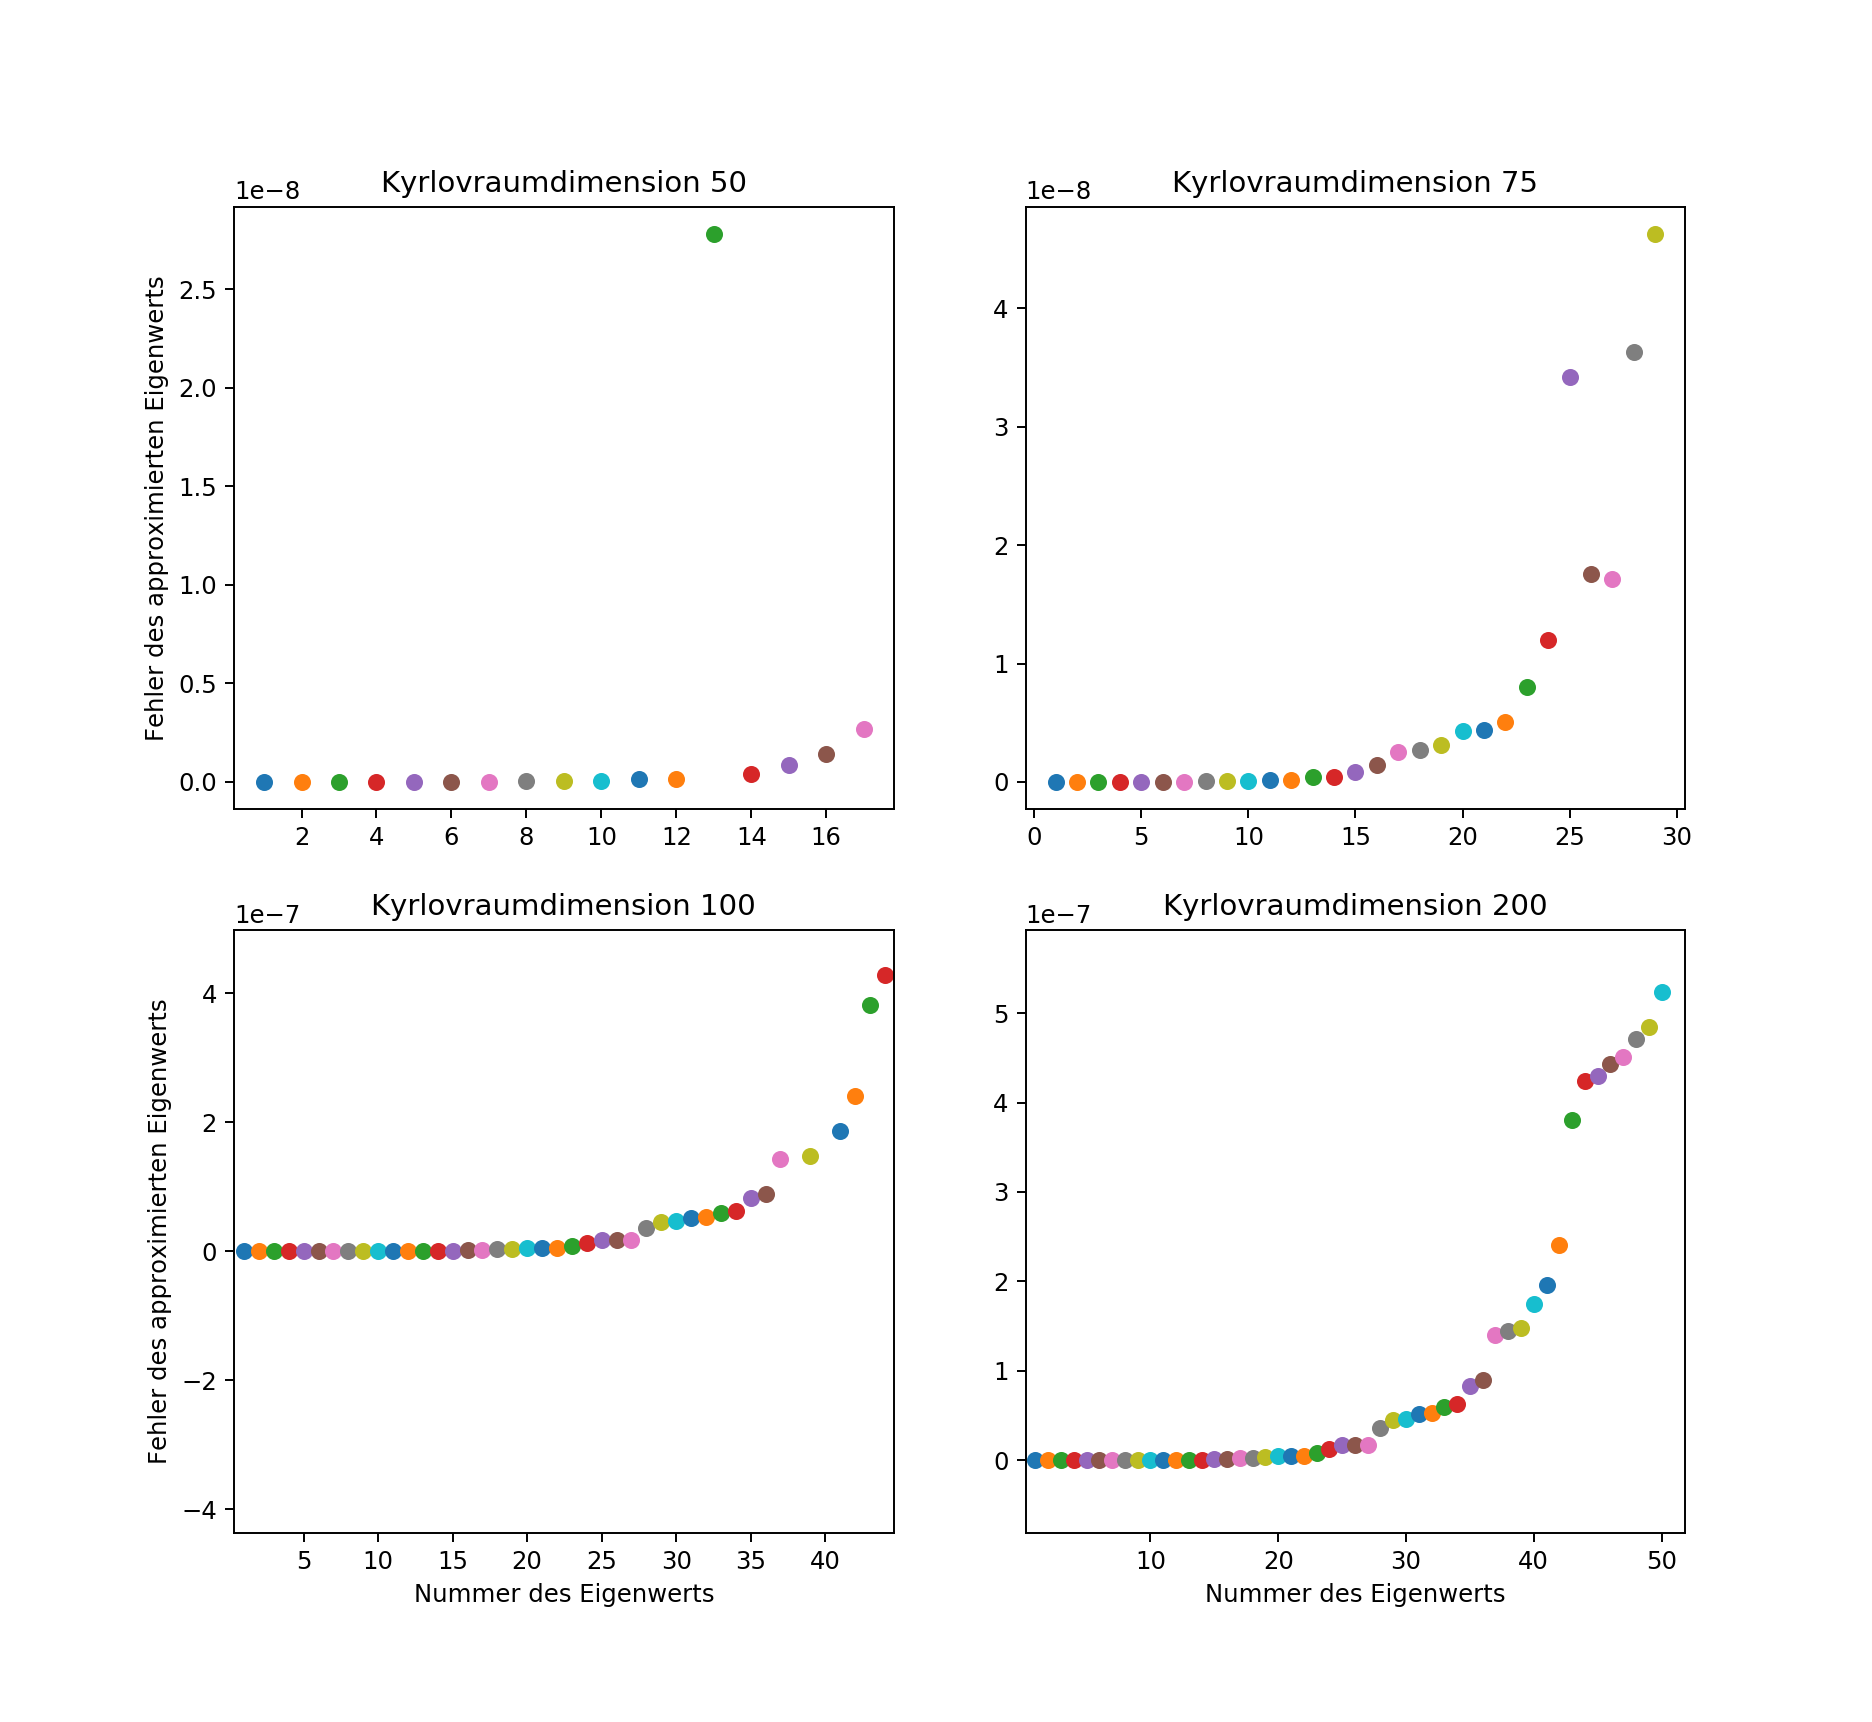

In [52]:
%matplotlib notebook

fig, axes  = plt.subplots(2, 2, figsize = (10,10))

for k in range(1,int(nr_eigs[0]*0.37)):
    axes[0][0].plot(k,abs(exact_arr[k]-lamsquared_1[k]), 'o')

for k in range(1,int(nr_eigs[1]*0.40)):
    axes[0][1].plot(k,abs(exact_arr[k]-lamsquared_2[k]), 'o')

for k in range(1,int(nr_eigs[2]*0.45)):
    axes[1][0].plot(k,abs(exact_arr[k]-lamsquared_3[k]), 'o')

for k in range(1,int(nr_eigs[3]*0.40)):
    axes[1][1].plot(k,abs(exact_arr[k]-lamsquared_4[k]), 'o')


axes[0][0].set_title("Kyrlovraumdimension {dim}".format(dim = nr_eigs[0]))
axes[0][0].set_ylabel("Fehler des approximierten Eigenwerts")
axes[0][1].set_title("Kyrlovraumdimension {dim}".format(dim = nr_eigs[1]))
axes[1][0].set_title("Kyrlovraumdimension {dim}".format(dim = nr_eigs[2]))
axes[1][0].set_xlabel("Nummer des Eigenwerts")
axes[1][0].set_ylabel("Fehler des approximierten Eigenwerts")
axes[1][1].set_title("Kyrlovraumdimension {dim}".format(dim = nr_eigs[3]))
axes[1][1].set_xlabel("Nummer des Eigenwerts")
plt.show()